In [2]:
#%config InlineBackend.figure_format = 'svg'
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
import qiskit.quantum_info as qi
import qiskit.circuit.library as qulib
from qiskit.compiler import transpile
from qiskit_textbook.tools import array_to_latex

# Implementation of n-qubit Oracle for Grover's Algorithm

### Overview

In Grover's algorithm, the Oracle, which contains the marked elements of interest in an unstructured search, is typically implemented by using a function $f(x)$ that returns $1$ if $x$ is equal to any of $n$ the marked elements $\{w_0, w_1, \dots, w_n \}$, or is equal to $0$ if $x$ is unmarked:


$$
f(x) = \left \{
\begin{array}{ll}
      0, \quad \text{if } x \in \{w_0, w_1, \dots, w_n \} \\
      1, \quad \text{if } x \notin \{w_0, w_1, \dots, w_n \} \\
\end{array}
\right.
$$


The Oracle is then constructed as a unitary $U_f$, which when operating on the statevector $| x \rangle$, flips its phase if $x$ is marked, or leaves the phase unchanged is $x$ is unmarked:


$$ U_f | x \rangle = (-1)^{f(x)} | x \rangle $$

This specific type of Oracle is known as a phase Oracle, since the information of the marked elements resides in the phase of the states. For example, for the case of 3 qubits, where elements $w_0 = 011$ and $w_1 = 110$ are marked, we can easily see that since:


$$
f(x) = \left \{
\begin{array}{ll}
      0, \quad \text{if } x = 011 \text{, or } x = 110 \\
      1, \quad \text{otherwise,} \\
\end{array}
\right.
$$


$U_f$ then corresponds to the diagonal matrix:


$$ 
U_f = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

This guarantees that when $|x \rangle = |011 \rangle $ or $|x \rangle = |110 \rangle $, the resultant state for the marked elements after applying the Oracle will have an additional phase of $\text{-}1$. Conversely, all other states remain unchanged.

### Unitary-Based Implementation 

Probably the simplest way to implement the $U_f$ Oracle in Qiskit is by constructing a unitary operator using the corresponding diagonal matrix. This can be easily done by defining the following function:

In [3]:
def phase_oracle(marked):  
    
    n = len(str(marked[0]))                 # Number of bits (need to add check for all elems being of same length)
    indices =  [int(i,2) for i in marked]   # List of row/column indices for each marked element
    Uf = np.identity(2**n)                  # Indentity matrix for phase oracle
    
    for ind in indices:
        Uf[ind,ind] = -1                    # Apply phase of -1 to marked element in phase oracle
    
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr, name = 'Uf (Oracle)')
    qc.unitary(Uf, range(n))
    
    return qc

The function `phase_oracle` takes as an argument the list of marked elements, and generates a quantum circuit with a unitary equal to $U_f$. Below we generate the circuit for the 3 qubit example from above with $|011 \rangle$ and $ |110 \rangle $ as our marked elements:

In [4]:
marked_elems = ['011','110']        # List of marked binary elements

Uf_cir = phase_oracle(marked_elems) # Create quantum circuit based on phase oracle with marked elems from above
Uf_unit = qi.Operator(Uf_cir)       # Turn quantum circuit into an operator to double-check we get the correct matrix

array_to_latex(Uf_unit.data)        # Print unitary

<IPython.core.display.Math object>

As expected, we get the unitary matrix of $U_f$. We can now use our circuit `Uf_cir` as a block for our phase Oracle inside Grover's algorithm:

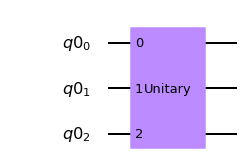

In [5]:
Uf_cir.draw('mpl')

We might also be interested in knowing how this circuit looks like at the gate level. For this, we would have to rely on a transpiler to convert the unitary into a circuit using a basis set of gates. The code below does this for using `[u3, cx]` as our basis gates:

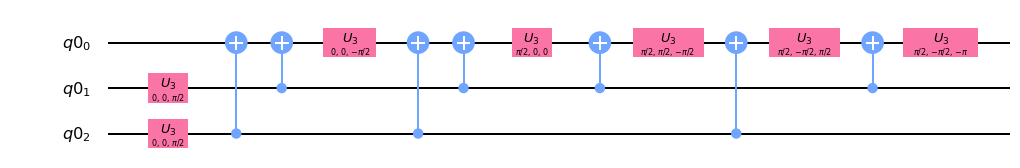

In [5]:
Uf_trans = transpile(Uf_cir, basis_gates = ['u3', 'cx'])
Uf_trans.draw('mpl', fold = 100)

This is all well and good, and for all practical purposes should suffice, but this approach does not provide us with any intuition on how the Oracle is really implemented at the circuit level. All we did was generated the diagonal matrix, and had the transpiler do the work of converting it to gates. There is however a different way to implement the oracle's circuit following a more systematic approach; this is by the use of controlled-z gates.

### Controlled-Z (CZ) Gates Implementation 

Perhaps a more intuitive way to implement the unitary $U_f$ for an arbitary number of qubits, is by the use of multi-qubit controlled-Z (CZ) gates, where the phase of a particular state is flipped when the connected qubits are all equal to 1. The simplest example of this is the 2-qubit `cz` gate shown below:

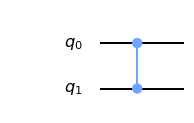

In [6]:
cz_cir1 = QuantumCircuit(2)
cz_cir1.cz(0,1)
cz_cir1.draw('mpl')

The unitary matrix for this gate is given by:

In [7]:
U_cz1 = qi.Operator(cz_cir1)
array_to_latex(U_cz1.data)

<IPython.core.display.Math object>

As can be seen, this is the same unitary for the 2-qubit phase oracle where the element $|11 \rangle$ is marked. We could slightly modify this circuit to generate an 2-qubit Oracle any marked element. For example, if we wanted to have the element $|10 \rangle$ marked, we would apply X gates to the `q1` qubit to make sure that the phase is flipped when that qubit is in state `0`:

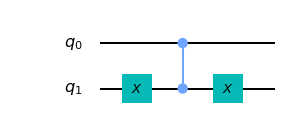

In [8]:
cz_cir2 = QuantumCircuit(2)
cz_cir2.x(1)
cz_cir2.cz(0,1)
cz_cir2.x(1)
cz_cir2.draw('mpl')

In [9]:
U_cz2 = qi.Operator(cz_cir2)
array_to_latex(U_cz2.data)

<IPython.core.display.Math object>

If the marked element was $|00 \rangle$, then we would need X gates in both `q0` and `q1`. 

Now, when we have more than one marked element, we would just concatenate the circuits needed for each of them:

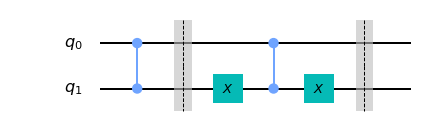

In [10]:
cz_cir3 = QuantumCircuit(2)
cz_cir3 = cz_cir3.compose(cz_cir1)
cz_cir3.barrier()
cz_cir3 = cz_cir3.compose(cz_cir2)
cz_cir3.barrier()
cz_cir3.draw('mpl')

In [11]:
cz_cir3.data.pop(1)           # Remove barriers (not supported by qi.Operator)
cz_cir3.data.pop(4)
U_cz3 = qi.Operator(cz_cir3)
array_to_latex(U_cz3.data)    # Print matrix

<IPython.core.display.Math object>

In the case of Oracles contatining more than 2 qubits, we will like to do the same. So for our previous example, where we had 3-qubits with $|011 \rangle$ and $ |110 \rangle $ as our marked elements, we would need to generate the following circuit for our oracle $U_f$:


<img src="images/3_qubit_Oracle.png" width = 500 style="float: left;"/>

This methodology can be easily generalized for $n$ qubits, allowing us to construct Oracles of any size in a way we can understand the inner works of the actual circuit at the gate level. In Qiskit, we can do this using a [Multi-Controlled Z-Rotation Gate (mcrz)](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mcrz.html). The mcrz gate rotates the state by an arbitrary angle $\lambda$, when all of its qubits are equal to 1. So to implement a multi-qubit controlled-Z gate, we will just need to pass $\lambda = \pi$ to the mcrz gate. 

Below we define a new phase oracle using this approach:

In [19]:
def phase_oracle2(marked, barrier = False):  
    
    n = len(str(marked[0]))  # Number of bits (need to add check for all elems being of same length)
    
    # define multi-qubit Controlled-Z circuit using an mcrz gate:
    lam = np.pi
    qr_control = QuantumRegister(n-1)
    qr_target = QuantumRegister(1)
    qc_cz = QuantumCircuit(qr_control, name = ' cz')
    qc_cz.add_register(qr_target)
    qc_cz.mcrz(lam,qr_control,qr_target[0])
    
    qc = QuantumCircuit(n, name = 'Uf (Oracle)')
    
    # For loop to generate the circuit needed for each of the marked elements:
    for elem in marked:
        mele = elem[::-1]  # Reverse element order to match qubit ordering
        
        # Loops through each element to apply x gate when a qubit is 0:
        for i in range(n):
            if mele[i] == '0':
                qc.x(i)
              
        qc.append(qc_cz,range(n)) # append mult-qubit CZ gate for each element in the list
        
        # Repeat For loop to apply x gate when qubit is 0:
        for i in range(n):    
            if mele[i] == '0':
                qc.x(i)
        
        if barrier == True:
            qc.barrier(range(n))        
    
    return qc

Now let's make sure this oracle generates the desired unitary $U_f$ for our example:

In [20]:
Uf_cir2 = phase_oracle2(marked_elems) # Create quantum circuit based on phase oracle with marked elems from above
Uf_unit2 = qi.Operator(Uf_cir2)       # Unitary matrix
array_to_latex(Uf_unit2.data)         # Print unitary

<IPython.core.display.Math object>

The unitary looks good! We can also draw the circuit to check that it actuall matches what we were looking for. Just note that the multi-qubit CZ gates will be displayed as blocks (labeled CZ) rather than straight lines connecting the qubits (as shown in the previous figure).

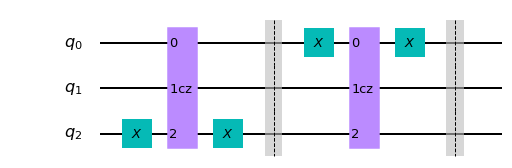

In [21]:
Uf_cir2 = phase_oracle2(marked_elems, barrier = True)
Uf_cir2.draw('mpl')

If we want to see how qiskit implements the CZ circuit using the `mcrz` gates, we can use the `decompose` method (X gates will be replaced with U3 rotations):

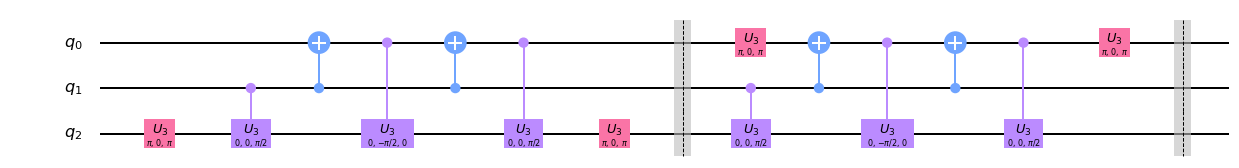

In [15]:
Uf_cir2.decompose().draw('mpl', fold = 100)

As we can see, this method also generates the expected unitary matrix we need for our Oracle, but now we have a better understanding of how the circuit was implemented to do so.

### Implementation using Qiskit's Diagonal Circuit

Qiskit's circuit library also includes an element that automatically generates a [diagonal circuit](https://qiskit.org/documentation/stubs/qiskit.circuit.library.Diagonal.html) based on the use of [Uniformily-Controlled Rz gate (UCRZ)](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.ucrz.html). These gates (also known as multiplexed gates), are a generalized version of a multi-qubit RZ gate, but where we can specify the angle of z-rotation for each combination of control qubits connected to the circuit. 

To use the diagonal circuit approach, all we need to do is pass an array with the diagonal elements we need, and Qiskit will generate corresponding UCRZ gates to obtain the phase rotations we specify. We can now do this for an n-qubit Oracle as follows:

In [16]:
def phase_oracle3(marked):

    n = len(str(marked[0]))                 # Number of bits (need to add check for all elems are being same length)
    indices =  [int(i,2) for i in marked]   # List of row/column indices for each marked element
    Uf_arr = np.ones(2**n)                  # Array for diagonal elements of phase oracle
    
    for ind in indices:  
        Uf_arr[ind] = -1                    # Apply phase of -1 to marked element in phase oracle

    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr, name = 'Uf (Oracle)')
    qc = qc.compose(qulib.Diagonal(Uf_arr),qr)  # Creates efficient diagonal circuit for phase oracle
    return qc

In [17]:
Uf_cir3 = phase_oracle3(marked_elems) # Create qc based on phase oracle with marked elems from above
Uf_unit3 = qi.Operator(Uf_cir3)       # Unitary matrix
array_to_latex(Uf_unit3.data)         # Print unitary

<IPython.core.display.Math object>

We can draw the circuit to see how qiskit uses the ucrz gates to generate this diagonal matrix:

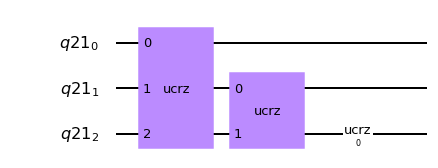

In [18]:
Uf_cir3.draw('mpl')